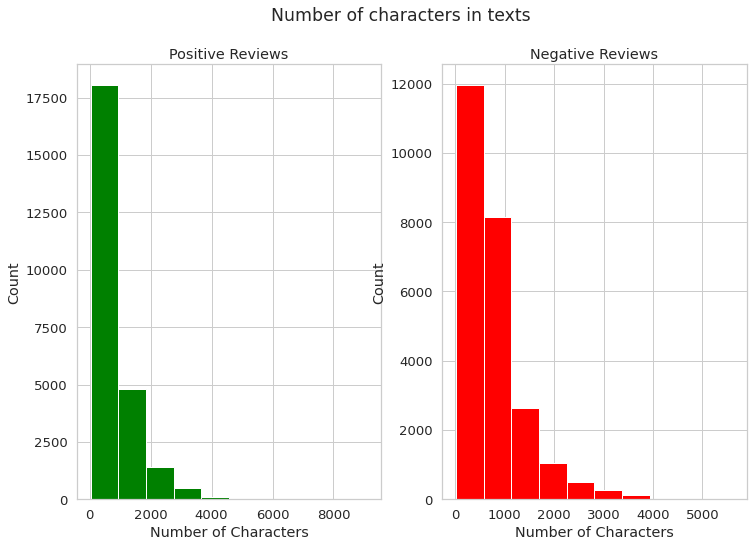

In [1]:
!pip install wandb

In [2]:
import wandb

In [3]:
wandb.login(key="509e34d1036abaa2034ee59d3dae5b090f6514ab")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [5]:
# ! pip install -U accelerate
# ! pip install -U transformers

In [6]:
!pip install trl pytorch-lightning

  Obtaining dependency information for trl from https://files.pythonhosted.org/packages/0d/44/c406c3cf5981bddb16ff72acb5ca235888db4073d868cf51bd143bef3aad/trl-0.7.4-py3-none-any.whl.metadata
  Obtaining dependency information for tyro>=0.5.11 from https://files.pythonhosted.org/packages/c5/11/abdf67467d06713b431618732a43f82d1b1f02120107b05a789afbcdf54d/tyro-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for shtab>=1.5.6 from https://files.pythonhosted.org/packages/40/ad/7227da64498eaa7abecee4311008f70869e156014b3270cec36e2e70cd31/shtab-1.6.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 11.1 MB/s eta 0:00:00


In [7]:
import torch
from torch import nn
import numpy as np
from datasets import Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline, TrainingArguments
from transformers import pipeline
from trl import DPOTrainer as DPOTrainer_init
from pytorch_lightning import seed_everything
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [8]:
seed_everything(42, workers=True)

42

In [9]:
TRAIN_HINGE = True
TRAIN_SIGMOID = True

# SFT model

In [10]:
model_name = "lvwerra/gpt2-imdb"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [11]:
starting_phrases = [
    "This movie is",
    "The acting was",
    "I think that this film",
    "The plot was",
]

number_of_samples = 10000
sequences_for_prompt = number_of_samples // len(starting_phrases)
batch_size = 200
max_length = 100
top_k = 50


In [12]:
def generate_texts(model, sequences_for_prompt=sequences_for_prompt, starting_phrases=starting_phrases):
    generated_texts = []
    for phrase in starting_phrases:
        encoded_input = tokenizer(phrase, return_tensors="pt").to(device)

        n_left_sequences = sequences_for_prompt
        cur_phrase_sequences = []

        while n_left_sequences > 0:
            generated_text = model.generate(**encoded_input,
                                            max_length=max_length,
                                            num_return_sequences=min(n_left_sequences, batch_size),
                                            pad_token_id=tokenizer.eos_token_id,#add top_k
                                            do_sample=True
                                            )
            n_left_sequences -= batch_size
            cur_phrase_sequences.extend([tokenizer.decode(generated_text[i], skip_special_tokens=True) for i in range(len(generated_text))])
            torch.cuda.empty_cache()

        generated_texts.append(cur_phrase_sequences)
    return generated_texts

In [13]:
generated_texts = generate_texts(model)

print(f"your dataset has {len(generated_texts) * batch_size} samples")
print("Generated texts:")

for x in generated_texts[0][:10]:
    print(x)

your dataset has 800 samples
Generated texts:
This movie is so bad it shouldn't even be listed.
This movie is about a woman who is getting murdered, her family is going to take care of her when he dies, she decides to join a group who are all trying to take revenge on his past so she can leave. The idea of all the young women on their own and taking revenge is really fun, it makes for a funny and touching film. There is a lot of character development that are very cool to watch, I was really surprised to find a lot of girls in the cast and I
This movie is a great comedy noir. It is funny but that was never going to be a problem.<br /><br />The story is very interesting. I don't agree with an author who writes about this in "Top Secret." Just because his book is not published on the American Film Academy standards did not make him a writer for this type of movie. I would say this movie is a great movie in it's own right, it is good entertainment but that is not its fault.<
This movie is

# Reward model

In [14]:
from transformers import pipeline
reward_model_name = "lvwerra/distilbert-imdb"
reward_model = pipeline("text-classification", reward_model_name, device=device)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
def score_texts(reward_model, generated_texts):
    rewards = []
    for batch in generated_texts:
        out = reward_model(batch, batch_size=batch_size)
        binary_scores = list(map(lambda x: x["score"] if x["label"] == "POSITIVE" else 1 - x["score"], out))
        rewards.append(np.array(binary_scores))
    return rewards

In [16]:
rewards = score_texts(reward_model, generated_texts)
print("text -> score")
for text, score in zip(generated_texts[0][:10], rewards[0][:10]):
    print(text[:100] + "...", score)

text -> score
This movie is so bad it shouldn't even be listed.... 0.0041390061378479
This movie is about a woman who is getting murdered, her family is going to take care of her when he... 0.9942613840103149
This movie is a great comedy noir. It is funny but that was never going to be a problem.<br /><br />... 0.9524638056755066
This movie is nothing like this: The movie takes place in Paris, at an important place, where French... 0.3992178440093994
This movie is the first movie to focus on the lives the boys at school experience in life. If you ar... 0.993016242980957
This movie is really, really bad. It's awful. It's a really, really, really bad movie. It's a really... 0.005022227764129639
This movie is about the journey of two men stranded on a desert planet called Eden. It is a great an... 0.12854361534118652
This movie is absolutely the best movie I have seen in a long time.<br /><br />I don't see a single ... 0.9196087718009949
This movie is the first-ever feature length version

# Creating dpo dataset

In [17]:
def create_dataset(num_samples, generated_texts, rewards):
    dataset = {
        "prompt": [],
        "chosen": [],
        "rejected": []
        }
    for i in range(num_samples):
        idx = np.random.randint(0, len(starting_phrases))

        first_example = np.random.randint(0, len(generated_texts[idx]))
        second_example = first_example

        while second_example == first_example:
            second_example = np.random.randint(0, len(generated_texts[idx]))

        first_score = rewards[idx][first_example]
        second_score = rewards[idx][second_example]

        if first_score > second_score:
            chosen = generated_texts[idx][first_example]
            rejected = generated_texts[idx][second_example]
        else:
            chosen = generated_texts[idx][second_example]
            rejected = generated_texts[idx][first_example]

        dataset["prompt"].append(starting_phrases[idx])
        dataset["chosen"].append(chosen)
        dataset["rejected"].append(rejected)
    dataset = Dataset.from_dict(dataset)
    return dataset

In [18]:
if TRAIN_HINGE or TRAIN_SIGMOID:
    num_samples = 64_000 # in paper they have 64k examples
    train_dataset = create_dataset(num_samples, generated_texts, rewards)

In [19]:
if TRAIN_HINGE or TRAIN_SIGMOID:
    val_texts = generate_texts(model, int(sequences_for_prompt * 0.2))
    val_rewards = score_texts(reward_model, val_texts)
    val_dataset = create_dataset(int(num_samples * 0.2), val_texts, val_rewards)

# Initializing dpo trainer

in paper they use loss
\begin{equation}
L(\theta) = \max(0, \delta - \log P_{\theta}(y_+|x) + \log P_{\theta}(y_-|x)) - \lambda \log P_{\theta}(y_{ref}|x)
\end{equation}

but in dpotrainer code we have 
\begin{equation}
L(\theta) = \max(0, \delta - \log P_{\theta}(y_+|x) + \log P_{\theta}(y_-|x) - \log P_{\theta_{ft}}(y_{-}|x) + \log P_{\theta_{ft}}(y_{+}|x))
\end{equation}

???????????

but model gives better results if i don't change anything in source code and it means that i missunderstood smth


UPD: жесть я дебил... в dpo лоссе мы учитываем политику sft, поэтому она тут и есть 

получается что если я хочу выучить slic-hf, то предсказания sft модели можно убрать ????????

\begin{equation}
f = \frac{u^{1-\alpha} - (1 - \alpha)u - \alpha}{\alpha(\alpha - 1)}
\end{equation}


\begin{equation}
f' = \frac{1 - u^{-\alpha}}{\alpha}
\end{equation}


In [20]:
def f_kl(chosen_log_probs, ref_chosen_log_probs, alpha=0.5):
    u = torch.exp(chosen_log_probs - ref_chosen_log_probs)
    u = torch.clamp(u, min=1e-12) 
    return (1 - u ** (-alpha)) / alpha

In [21]:
class DPOTrainer(DPOTrainer_init):
    def __init__(self, *args, **kwargs):
        super(DPOTrainer, self).__init__(*args, **kwargs)
        self.beta = 0.1
        self.f_kl_alpha = 0.5
        self.label_smoothing=0
    def dpo_loss(
        self,
        policy_chosen_logps: torch.FloatTensor,
        policy_rejected_logps: torch.FloatTensor,
        reference_chosen_logps: torch.FloatTensor,
        reference_rejected_logps: torch.FloatTensor,
        reference_free: bool = False,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        # changed code starts here
        f1 = f_kl(policy_chosen_logps, reference_chosen_logps, self.f_kl_alpha)
        f2 = f_kl(policy_rejected_logps, reference_rejected_logps, self.f_kl_alpha)
        

        logits = f1 - f2
        # ends here
        # The beta is a temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5.
        # We ignore the reference model as beta -> 0. The label_smoothing parameter encodes our uncertainty about the labels and
        # calculates a conservative DPO loss.
        if self.loss_type == "sigmoid":
            losses = (
                -F.logsigmoid(self.beta * logits) * (1 - self.label_smoothing)
                - F.logsigmoid(-self.beta * logits) * self.label_smoothing
            )
        elif self.loss_type == "hinge":
            losses = torch.relu(1 - self.beta * logits)
        elif self.loss_type == "ipo":
            # eqn (17) of the paper where beta is the regularization parameter for the IPO loss, denoted by tau in the paper.
            losses = (logits - 1 / (2 * self.beta)) ** 2
        elif self.loss_type == "kto":
            # eqn (7) of the HALOs paper
            chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
            rejected_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

            chosen_logratios = policy_chosen_logps - reference_chosen_logps
            rejected_logratios = policy_rejected_logps - reference_rejected_logps
            # As described in the KTO report, the KL term for chosen (rejected) is estimated using the rejected (chosen) half.
            losses = torch.cat(
                (
                    1 - F.sigmoid(self.beta * (chosen_logratios - rejected_KL)),
                    1 - F.sigmoid(self.beta * (chosen_KL - rejected_logratios)),
                ),
                0,
            )
        else:
            raise ValueError(
                f"Unknown loss type: {self.loss_type}. Should be one of ['sigmoid', 'hinge', 'ipo', 'kto']"
            )

        chosen_rewards = self.beta * (policy_chosen_logps - reference_chosen_logps).detach()
        rejected_rewards = self.beta * (policy_rejected_logps - reference_rejected_logps).detach()
        return losses, chosen_rewards, rejected_rewards

In [22]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [23]:
from scipy.stats import entropy
from collections import defaultdict
def token_entropy(generations, tokenizer):
    stats = defaultdict(int)
    num_tokens = 0
    for example in generations:
        tokens = tokenizer.encode(example)
        for t in tokens:
            if t == tokenizer.pad_token_id:
                continue
            stats[t] += 1
            num_tokens += 1
    for k in stats.keys():
        stats[k] /= num_tokens
    return entropy(list(stats.values()))

In [24]:
init_entropy = token_entropy(flatten(generated_texts), tokenizer)

# Sigmoid loss

In [25]:
if TRAIN_SIGMOID:
    sigmoid_model = GPT2LMHeadModel.from_pretrained(model_name)
    model_ref = GPT2LMHeadModel.from_pretrained(model_name) # don't need it? 

In [26]:
if TRAIN_SIGMOID:
    training_args = TrainingArguments(
        output_dir='./results/sigmoid',
        num_train_epochs=1,
        per_device_train_batch_size=16,
        learning_rate=1e-5,
        eval_steps=600,
        save_strategy="steps",
        evaluation_strategy="steps",
        logging_steps=40
    )

In [27]:
if TRAIN_SIGMOID:
    save_path = 'sigmoid_model'
    !mkdir {save_path} 
    model.save_pretrained(save_path)
    !zip -r model.zip {save_path}

  adding: sigmoid_model/ (stored 0%)
  adding: sigmoid_model/model.safetensors (deflated 7%)
  adding: sigmoid_model/config.json (deflated 51%)
  adding: sigmoid_model/generation_config.json (deflated 24%)


In [28]:
if TRAIN_SIGMOID:
    dpo_trainer = DPOTrainer(
        sigmoid_model,
        model_ref,
        beta=0.1,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        loss_type="sigmoid",
        max_length=max_length,
        max_prompt_length=max(list(map(lambda x: len(x), starting_phrases))),
    )

/opt/conda/lib/python3.10/site-packages/trl/trainer/dpo_trainer.py:291: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


In [29]:
if TRAIN_SIGMOID:
    dpo_trainer.train()

wandb: Currently logged in as: maksimsilenko8. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231212_003536-3zolzlh8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run proud-glitter-15
wandb: ⭐️ View project at https://wandb.ai/maksimsilenko8/huggingface
wandb: 🚀 View run at https://wandb.ai/maksimsilenko8/huggingface/runs/3zolzlh8
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
600,6.149200,0.723589,0.003130,-0.351159,0.796953,0.354288,-197.126480,-188.710052,-30.696169,-30.799646
1200,1.038400,0.626248,0.236529,-0.125351,0.772812,0.361880,-194.868423,-186.376068,-34.198803,-34.215759
1800,2.218900,1.431359,0.119542,-0.341257,0.801406,0.460799,-197.027466,-187.545914,-34.481647,-34.642220
2400,5.480600,1.571349,0.072411,-0.410055,0.806328,0.482466,-197.715454,-188.017227,-33.421829,-33.610008
3000,11.696900,1.275029,0.079344,-0.382170,0.805156,0.461515,-197.436584,-187.947891,-33.146347,-33.251671
3600,2.301700,1.637549,0.025211,-0.455436,0.817266,0.480647,-198.169250,-188.489258,-33.251415,-33.382549


In [30]:
if not TRAIN_SIGMOID:
    sigmoid_model = GPT2LMHeadModel.from_pretrained("/kaggle/input/gpt2-alignment/" + save_path, return_dict=True).to(device)

In [31]:
sigmoid_model_texts = generate_texts(sigmoid_model, sequences_for_prompt=int(sequences_for_prompt * 0.2), starting_phrases=["i think that", "basically"]) 
sigmoid_model_rewards = score_texts(reward_model, sigmoid_model_texts)

In [32]:
dpo_trainer.state.log_history

[{'loss': 0.7851,
  'learning_rate': 9.9e-06,
  'rewards/chosen': -0.18502356112003326,
  'rewards/rejected': -0.309745192527771,
  'rewards/accuracies': 0.7171875238418579,
  'rewards/margins': 0.12472162395715714,
  'logps/rejected': -194.03585815429688,
  'logps/chosen': -189.22830200195312,
  'logits/rejected': -28.519134521484375,
  'logits/chosen': -27.49651527404785,
  'epoch': 0.01,
  'step': 40},
 {'loss': 1.1802,
  'learning_rate': 9.800000000000001e-06,
  'rewards/chosen': -0.0918949544429779,
  'rewards/rejected': -0.2884413003921509,
  'rewards/accuracies': 0.739062488079071,
  'rewards/margins': 0.19654634594917297,
  'logps/rejected': -192.9195556640625,
  'logps/chosen': -188.43226623535156,
  'logits/rejected': -29.29947280883789,
  'logits/chosen': -28.826892852783203,
  'epoch': 0.02,
  'step': 80},
 {'loss': 0.6642,
  'learning_rate': 9.7e-06,
  'rewards/chosen': -0.146377831697464,
  'rewards/rejected': -0.4251956343650818,
  'rewards/accuracies': 0.776562511920929

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'sigmoid model reward distribution'}, ylabel='Count'>

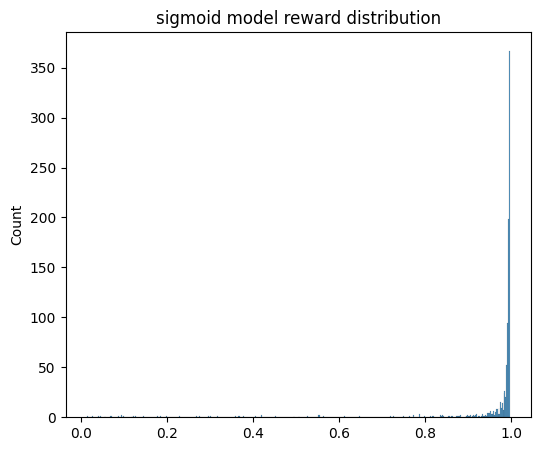

In [33]:
plt.figure(figsize=(6, 5))
plt.title("sigmoid model reward distribution")
sns.histplot(flatten(sigmoid_model_rewards))

In [34]:
np.array(flatten(sigmoid_model_rewards)).mean()

0.9532670246958732

In [35]:
sigmoid_model_entropy = token_entropy(flatten(sigmoid_model_texts), tokenizer)

In [36]:
sigmoid_model_entropy

5.828981342740228

In [37]:
init_entropy

6.024373097251457

In [38]:
prompts = [
    "one reviewer",
    "Petter Mattei's",
    "Encouraged by the positive comments"
]

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'sigmoid model reward distribution'}, ylabel='Count'>

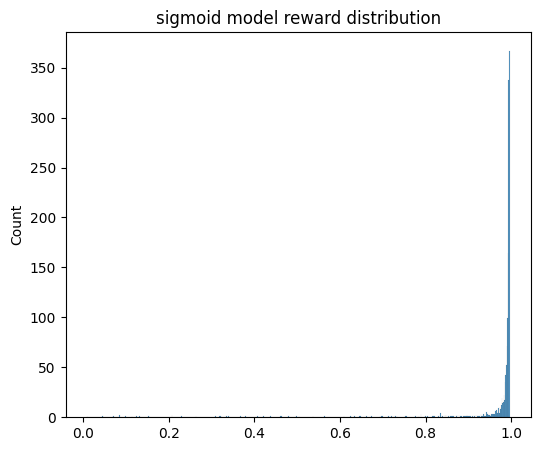

In [39]:
test_texts = generate_texts(sigmoid_model, sequences_for_prompt=int(sequences_for_prompt * 0.2), starting_phrases=prompts) 
test_rewards = score_texts(reward_model, test_texts)
plt.figure(figsize=(6, 5))
plt.title("sigmoid model reward distribution")
sns.histplot(flatten(test_rewards))

In [40]:
test_texts[1][-10:]

['Petter Mattei\'s latest film, "The Man Who Fell Alone In Love With Love" also contains a fantastic score and a good ending.<br /><br />This also contains some strong material--it\'s a very interesting, witty, and enjoyable movie for one season only. But please don\'t expect to find any special features at all. It\'s just a nice, witty, and amusing watch if you can spare less than 5 minutes of the day. Don\'t rent this movie at a',
 'Petter Mattei\'s first (and even better!) performance as a man in love with one\'s own. While it\'s great to see the story turn from "What\'s the point?" to "All I Love Is Love, Love and Everything That\'s Left" a long, satisfying journey, there is no ending but this is a good ending with some heartwarming moments. And there are many more memorable moments in a film that will really add to your interest and heart.',
 "Petter Mattei's voice) is excellent and they are both beautifully animated and the film is great. It is about a man called Gertrude (the wi